In [1]:
import numpy as np 
import matplotlib.pyplot as plt

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['figure.dpi'] = 100

## Question 1

I could not figure out how to use the C pseudo-random number generator given by Jon. So I'll just use the txt file provided. Also, I'll check if the Python (```numpy.random.randint```) PRNG is flawed or not.

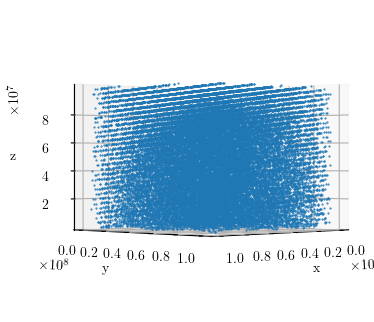

In [2]:
# flawed C-PRNG
# loading the txt file provided
points=np.loadtxt('rand_points.txt')
x=points[:,0]
y=points[:,1]
z=points[:,2]

# plotting stuff
fig=plt.figure()
ax=fig.add_subplot(projection='3d')
ax.plot(x,y,z,'.',markersize='1')
ax.view_init(0, 45)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

We can see lines; it really does look like the 'randomly' generated points lie on a set of planes! Not so random.

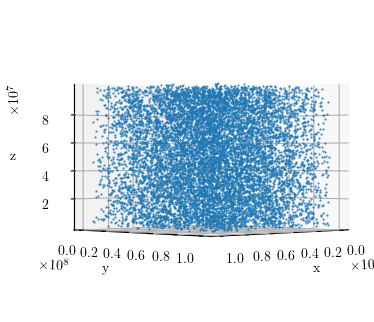

In [3]:
# Numpy PRNG
# getting (x,y,z) coordinates between 0 and 1e8, using numpy random number generator
x=[];y=[];z=[]
for i in range(10000):
    x.append(np.random.randint(0,1e8))
    y.append(np.random.randint(0,1e8))
    z.append(np.random.randint(0,1e8))

# plotting stuff
fig=plt.figure()
ax=fig.add_subplot(projection='3d')
ax.plot(x,y,z,'.',markersize=1)
ax.view_init(0, 45)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

It does not look like the points lie on a set of planes; completely randomly generated points!

## Question 2

Theoretically, I could use any of the Lorentzians, Gaussians or power laws to generate the exponential deviates, so long as the bounding distribution is greater than the exponential for all values of $x$. The Gaussian function will be a little harder to use, because the CDF does not really have simple form (it is the ERF, error function), but I dont doubt that it is possible to work with it in Python. However, in this question I will just use the Lorentzian because why not.



A Lorentzian has the form: $\text{PDF}(x)=\frac{1}{1+x^2}$. So the CDF is:

$$\text{CDF}(x)=\int_0^{x}\frac{1}{1+x^2}dx=\arctan{(x)}$$

Set the CDF equal to some random number between 0 and 1:

$$\text{CDF}(x)=\arctan{(x)}=r.$$

Solve for $x$:

$$x=\tan{(r)}.$$


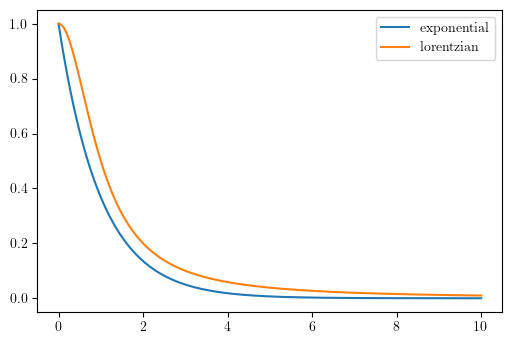

all good


In [9]:
# relation we derived above: x=tan(r)
def lorentzian(n):
    r=np.pi*(np.random.rand(n)-0.5) # tan only takes numbers between -pi and pi
    return np.tan(r)

# first let's check if the Lorentzian is always above the exponential we want to generate
x=np.linspace(0,10,1001)

def model(x):
    return np.exp(-x) 

def lorentz(x):
    return 1/(1+x**2)

plt.plot(x,model(x),label='exponential')
plt.plot(x,lorentz(x),label='lorentzian')
plt.legend()
plt.show()
print('all good')

C:\Users\Greg\AppData\Local\Temp\ipykernel_3820\1798579393.py:10: RuntimeWarning: overflow encountered in exp
  return np.exp(-x)


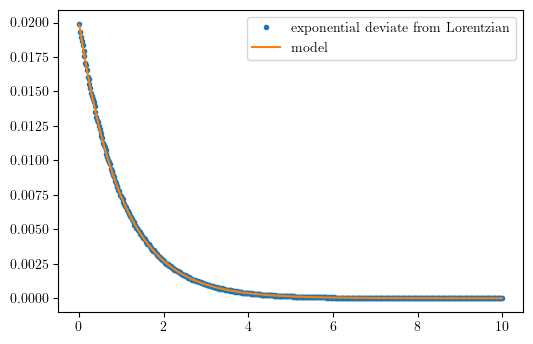

Effeciency of generator is:  81.80398


In [54]:
n=10000000 # number of random numbers

# generating the non-uniform random numbers
l=lorentzian(n)
u=lorentz(l)*np.random.rand(n) 

# seletcing only those that lie *below* the exponential
accept=u<model(l)
use=l[accept]

# effeciency (how many samples we actually use)
eff=np.size(use)/np.size(accept)*100

# plotting stuff
a,b=np.histogram(use,np.linspace(0,10,500))
a=a/a.sum()
bb=0.5*(b[1:]+b[:-1]) # get center of bins
pred=model(bb)
pred=pred/pred.sum()

plt.plot(bb,a,'.', label='exponential deviate from Lorentzian')
plt.plot(bb,pred,label='model')
plt.legend()
plt.show()
print('Effeciency of generator is: ',eff)

Looks good!

## Question 3

Same as problem 2, but now I use a ratio-of-uniforms generator.

The math is that we take a $(u,v)$ plane, where
$$0<u<\sqrt{\text{PDF}(v/u)}.$$
In our case, $\text{PDF}(x)=e^{-x}$ and $u$ runs from 0 to 1

So we have
$$0<u<\sqrt{e^{-v/u}},$$
$$0<u^2<e^{-v/u},$$
$$\ln{(0)}<\ln{(u^2)}<-v/u,$$
$$\ln{(0)}>-2u\ln{(u)}>v.$$

$\ln{0}=\infty$ so we can discard that bound (of course $v$ will always be smaller than $\infty$). So we are left with

$$-2u\ln{(u)}>v.$$

To find the upper bound on $v$ (the lower bound is 0) let's pick the $u$, between 0 and 1, that will maximize $-2u\ln{(u)}$

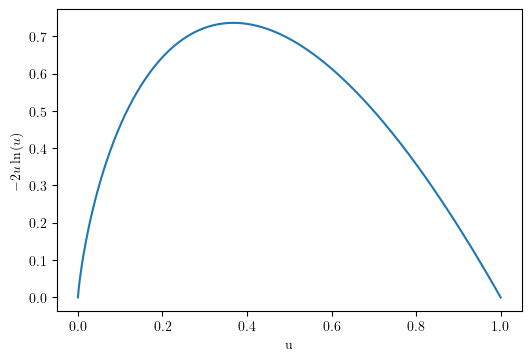

In [25]:
x=np.linspace(0.0000001,1,1001)
plt.plot(x,-2*x*np.log(x))
plt.xlabel('u')
plt.ylabel('$-2u\ln{(u)}$')
plt.show()

There is one extremum (it is a maximum) betweem 0 and 1 so let's take the derivative and set it equal to zero:
$$\frac{d}{du}\left(-2u\ln{(u)}\right)=-2-2\ln{(u)}=0,$$
$$\ln{u}=-1,$$
$$u=e^{-1}.$$

So the upper bound on $v$ is $-2(e^{-1})\ln{(e^{-1})}=2e^{-1}$.

Since the lower bound is 0:

$$0<v<2e^{-1}.$$

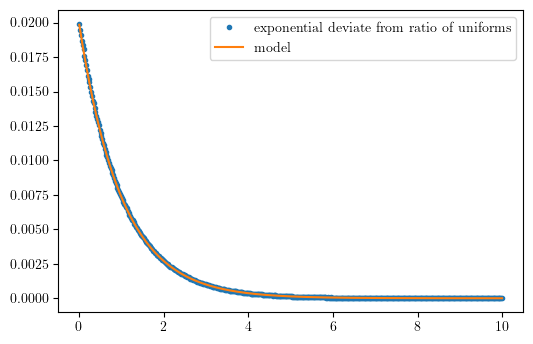

Effeciency of generator is:  67.96546


In [52]:
n=10000000 # number of random numbers

u=np.random.rand(n) # random numbers from 0 to 1
v=(np.random.rand(n))*2*np.exp(-1) # random numbers from 0 to e^-1

# ratio of uniforms
a=u<np.sqrt(np.exp(-v/u))
use=v[a]/u[a]

# effeciency (how many ratios we actually use)
eff=np.size(use)/np.size(a)*100

# plotting stuff
a,b=np.histogram(use,np.linspace(0,10,500))
a=a/a.sum()
bb=0.5*(b[1:]+b[:-1]) # get center of bins
pred=model(bb)
pred=pred/pred.sum()

plt.plot(bb,a,'.', label='exponential deviate from ratio of uniforms')
plt.plot(bb,pred,label='model')
plt.legend()
plt.show()

print('Effeciency of generator is: ',eff)

Not bad!!